## Shuzhan Fan, Oct 2018

### Import packages

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re 
from time import time
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
from wordcloud import WordCloud
from tqdm import tqdm
import multiprocessing
from scipy.stats import hmean, norm
import gensim
from gensim.models.word2vec import Word2Vec
from gensim.models.doc2vec import TaggedDocument
from gensim.models import KeyedVectors
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import utils
from sklearn.preprocessing import scale
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.embeddings import Embedding
from keras.layers import Input, concatenate, Activation
from keras.layers import Conv1D, GlobalMaxPooling1D, LSTM
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
%matplotlib inline
plt.style.use("seaborn-darkgrid")

In [3]:
df1_col_names = ['sentiment','id','date','query_string','user','text']
df1 = pd.read_csv("data/sentiment140_training.csv", header=None, names=df1_col_names)
df2 = pd.read_csv("data/nieksanders_full.csv", header="infer")
df3 = pd.read_csv("data/umich_training.txt", header=None, sep="\t")

### Drop useless columns

In [4]:
df1.drop(['id','date','query_string','user'], axis=1, inplace=True)
df2.drop(['Topic','TweetId','TweetDate'], axis=1, inplace=True)
df2.columns = ['sentiment', 'text']
df3.columns = ['sentiment', 'text']

### Map sentiment value to 0 or 1

In [5]:
df1['sentiment'] = df1['sentiment'].apply(lambda x: 1 if x==4 else x)
df2 = df2.loc[(df2['sentiment'] == 'positive') | (df2['sentiment'] == 'negative')]
df2['sentiment'] = df2['sentiment'].apply(lambda x: 1 if x=="positive" else 0)

### Concat three data sets

In [6]:
df = pd.concat([df1, df2, df3])
df.reset_index(inplace=True)

### Data preprocessing

In [7]:
html_pattern = r"https?://[^ ]+"
www_pattern = r"www.[^ ]+"
user_pattern = r"@[A-Za-z0-9_]+"
url_user_pattern = r"|".join((html_pattern, www_pattern, user_pattern))
negations = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
             "don't":"do not", "doesn't":"does not", "didn't":"did not",
             "haven't":"have not", "hasn't":"has not", "hadn't":"had not",
             "won't":"will not", "wouldn't":"would not",
             "can't":"can not", "couldn't":"could not",
             "shouldn't":"should not",
             "mightn't":"might not",
             "mustn't":"must not"}
negations_pattern = re.compile(r'\b(' + '|'.join(negations.keys()) + r')\b')
tokenizer = WordPunctTokenizer()

def clean_tweet(tweet):
    soup = BeautifulSoup(tweet, "lxml")
    souped = soup.get_text()
    url_clean = re.sub(url_user_pattern, "", souped)
    try:
        bom_clean = url_clean.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        bom_clean = url_clean
    negation_clean = negations_pattern.sub(lambda x: negations[x.group()], bom_clean)
    letters_only = re.sub("[^a-zA-Z]", " ", negation_clean)
    lower = letters_only.lower()
    words = [x for x in tokenizer.tokenize(lower) if len(x) > 1]
    tweet_clean = (" ".join(words)).strip()
    return tweet_clean

### Clean tweets and save results

In [8]:
%%time
tweets_cleaned = []
for i in xrange(0, len(df)):
    if ((i+1) % 100000) == 0:
        print "Tweets %d of %d has been processed" % ( i+1, len(df) )
    tweets_cleaned.append(clean_tweet(df.text[i]))

df_cleaned = pd.DataFrame(tweets_cleaned, columns=["text"])
df_cleaned["target"] = df.sentiment
df_cleaned.to_csv("tweets_cleaned.csv", encoding="utf-8")

/home/shuzhan/anaconda2/lib/python2.7/encodings/utf_8_sig.py:19: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if input[:3] == codecs.BOM_UTF8:


Tweets 100000 of 1608009 has been processed
Tweets 200000 of 1608009 has been processed
Tweets 300000 of 1608009 has been processed
Tweets 400000 of 1608009 has been processed
Tweets 500000 of 1608009 has been processed
Tweets 600000 of 1608009 has been processed
Tweets 700000 of 1608009 has been processed
Tweets 800000 of 1608009 has been processed
Tweets 900000 of 1608009 has been processed
Tweets 1000000 of 1608009 has been processed
Tweets 1100000 of 1608009 has been processed
Tweets 1200000 of 1608009 has been processed
Tweets 1300000 of 1608009 has been processed
Tweets 1400000 of 1608009 has been processed
Tweets 1500000 of 1608009 has been processed
Tweets 1600000 of 1608009 has been processed
CPU times: user 8min 26s, sys: 7.01 s, total: 8min 33s
Wall time: 8min 33s


### Read cleaned tweets and drop NaN rows

In [9]:
df_clean = pd.read_csv("tweets_cleaned.csv", index_col=0)
df_clean.dropna(inplace=True)
df_clean.reset_index(drop=True, inplace=True)

/home/shuzhan/anaconda2/lib/python2.7/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [10]:
df_clean["target"].value_counts()

1    802296
0    801726
Name: target, dtype: int64

### Plot WordCloud for positive and negative tweets

In [11]:
df_positive = df_clean[df_clean["target"]==1]
df_negative = df_clean[df_clean["target"]==0]
np_positive = df_positive.text.values
np_negative = df_negative.text.values
text_positive = pd.Series(np_positive).str.cat(sep=" ")
text_negative = pd.Series(np_negative).str.cat(sep=" ")
wc_positive = WordCloud(width=1800, height=1000, max_font_size=250).generate(text_positive)
wc_negative = WordCloud(width=1800, height=1000, max_font_size=250).generate(text_negative)

(-0.5, 1799.5, 999.5, -0.5)

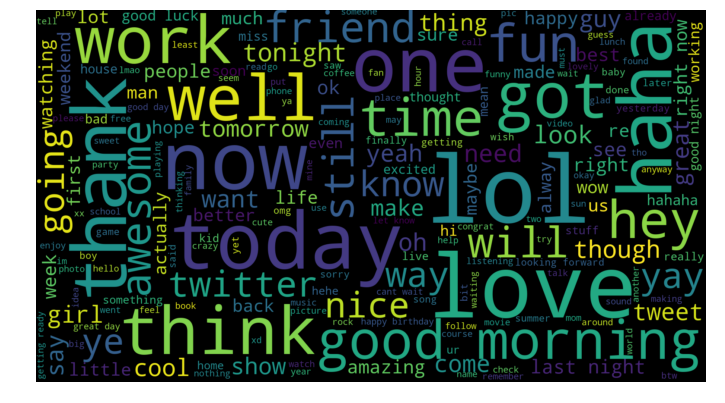

In [12]:
plt.figure(figsize=(12,10))
plt.imshow(wc_positive, interpolation="bilinear")
plt.axis("off")

(-0.5, 1799.5, 999.5, -0.5)

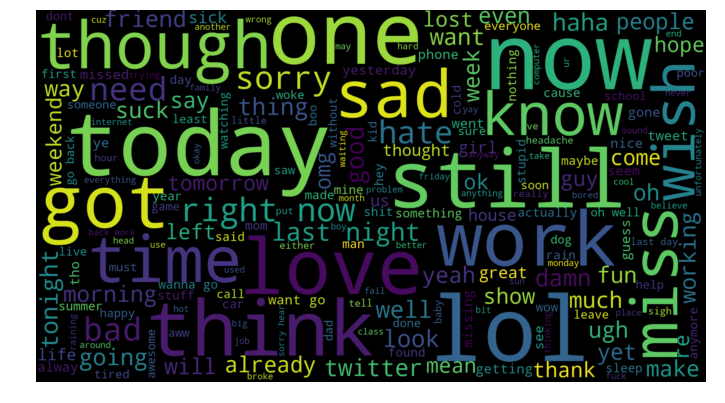

In [13]:
plt.figure(figsize=(12,10))
plt.imshow(wc_negative, interpolation="bilinear")
plt.axis("off")

### Explore positive and negative words

In [17]:
count_vectorizer = CountVectorizer()
count_vectorizer.fit(df_clean.text)
mat_positive = count_vectorizer.transform(df_clean[df_clean.target==1].text)
mat_negative = count_vectorizer.transform(df_clean[df_clean.target==0].text)
tf_positive  = np.sum(mat_positive, axis=0)
tf_negative  = np.sum(mat_negative, axis=0)
np_positive  = np.squeeze(np.asarray(tf_positive))
np_negative  = np.squeeze(np.asarray(tf_negative))
df_tf = pd.DataFrame([np_negative,np_positive], columns=count_vectorizer.get_feature_names()).transpose()
df_tf.columns = ["negative", "positive"]
df_tf["total"] = df_tf.negative + df_tf.positive

In [18]:
def positive_harmonic_mean(x):
    pr  = x["positive_rate"]
    pfp = x["positive_relative_frequency"]
    if pr > 0 and pfp > 0:
        return hmean([pr, pfp])
    else:
        return 0

def negative_harmonic_mean(x):
    nr  = x["negative_rate"]
    nfp = x["negative_relative_frequency"]
    if nr > 0 and nfp > 0:
        return hmean([nr, nfp])
    else:
        return 0
      
def normcdf(x):
    return norm.cdf(x, x.mean(), x.std())

df_tf["positive_rate"] = df_tf["positive"]*1. / df_tf["total"]
df_tf['positive_relative_frequency'] = df_tf['positive'] * 1./df_tf['positive'].sum()
df_tf["positive_rate_normcdf"]     = normcdf(df_tf["positive_rate"])
df_tf["positive_relative_frequency_normcdf"] = normcdf(df_tf["positive_relative_frequency"])
df_tf["positive_normcdf_harmonic_mean"]    = hmean([df_tf["positive_rate_normcdf"], df_tf["positive_relative_frequency_normcdf"]])
df_tf["negative_rate"]             = df_tf["negative"] * 1. / df_tf["total"]
df_tf["negative_relative_frequency"]         = df_tf["negative"] * 1. / df_tf["negative"].sum()
df_tf["negative_rate_normcdf"]     = normcdf(df_tf["negative_rate"])
df_tf["negative_relative_frequency_normcdf"] = normcdf(df_tf["negative_relative_frequency"])
df_tf["negative_normcdf_harmonic_mean"]    = hmean([df_tf["negative_rate_normcdf"], df_tf["negative_relative_frequency_normcdf"]])

In [19]:
df_tf.drop(['positive_rate', 'negative_rate', 'positive_relative_frequency', 'negative_relative_frequency', 'positive_rate_normcdf', 'negative_rate_normcdf', 'positive_relative_frequency_normcdf', 'negative_relative_frequency_normcdf'], axis=1, inplace=True)
df_tf.to_csv("term_frequencies.csv", encoding="utf-8")

### Plot top 30 positive and negative tokens

In [20]:
df_tf = pd.read_csv("term_frequencies.csv", index_col=0)

In [21]:
y_coords = np.arange(20)
df_tf_positive_sorted = df_tf.sort_values(by="positive_normcdf_harmonic_mean", ascending=False)["positive_normcdf_harmonic_mean"][:20]
df_tf_negative_sorted = df_tf.sort_values(by="negative_normcdf_harmonic_mean", ascending=False)["negative_normcdf_harmonic_mean"][:20]

Text(0,0.5,'Words')

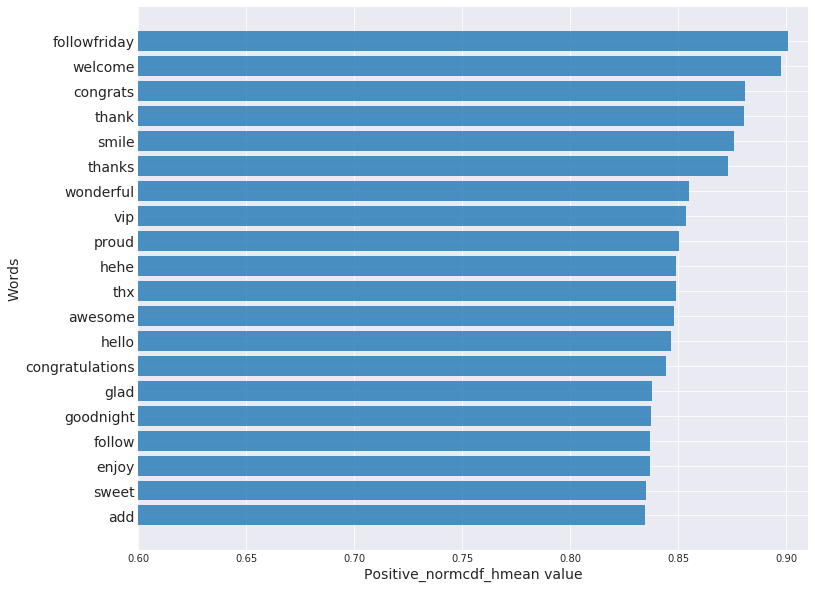

In [22]:
plt.figure(figsize=(12,10))
plt.barh(-y_coords, df_tf_positive_sorted, align="center", alpha=0.8)
plt.yticks(-y_coords, df_tf_positive_sorted.index, rotation="horizontal", fontsize=14)
plt.xlabel("Positive_normcdf_hmean value", fontsize=14)
plt.xlim((0.60, 0.91))
plt.ylabel("Words", fontsize=14)

Text(0,0.5,'Words')

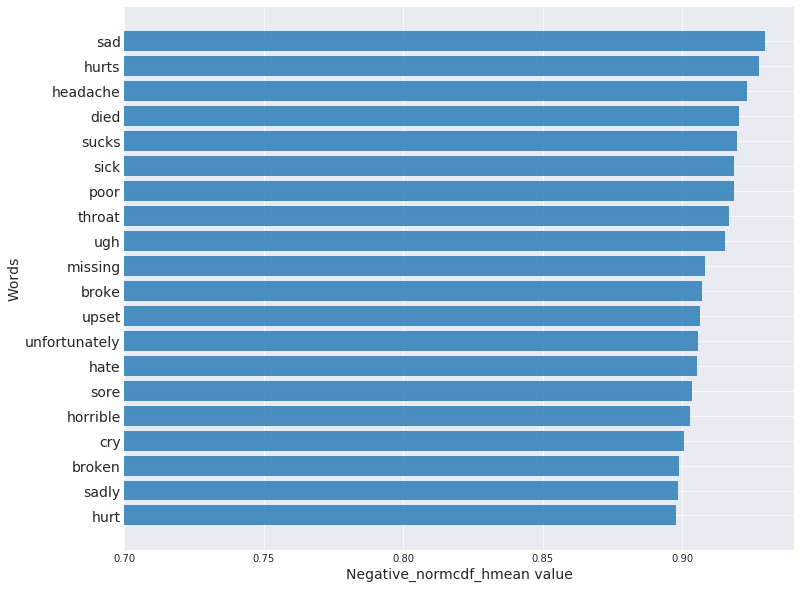

In [23]:
plt.figure(figsize=(12,10))
plt.barh(-y_coords, df_tf_negative_sorted, align="center", alpha=0.8)
plt.yticks(-y_coords, df_tf_negative_sorted.index, rotation="horizontal", fontsize=14)
plt.xlabel("Negative_normcdf_hmean value", fontsize=14)
plt.xlim((0.70, 0.94))
plt.ylabel("Words", fontsize=14)

### Feature extraction: Word2Vec

In [11]:
tqdm.pandas(desc="progress-bar")
cpus = multiprocessing.cpu_count()

In [2]:
df_clean = pd.read_csv("tweets_cleaned.csv", index_col=0)
df_clean.dropna(inplace=True)
df_clean.reset_index(drop=True, inplace=True)
X = df_clean.text
y = df_clean.target
X_train, X_vali_test, y_train, y_vali_test = train_test_split(X, y, test_size=0.02, random_state=8081)
X_vali, X_test, y_vali, y_test = train_test_split(X_vali_test, y_vali_test, test_size=0.5, random_state=8081)

/home/shuzhan/anaconda2/lib/python2.7/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [5]:
def tag_documents(tweets, prefix):
    tagged_tweets = []
    for i, t in zip(tweets.index, tweets):
        tagged_tweets.append(TaggedDocument(t.split(), [prefix + str(i)]))
    return tagged_tweets
X_tagged = tag_documents(X, 'tweet_')

def tweet_word2vec(tweet, size, model, aggr):
    tweet_vecs = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tweet.split():
        try:
            tweet_vecs += model[word].reshape((1, size))
            count += 1.
        except KeyError:
            continue
    if aggr == 'mean':
        if count != 0:
            tweet_vecs /= count
        return tweet_vecs
    elif aggr == 'sum':
        return tweet_vecs
    
def tweet_word2vec_concat(tweet, size, model1, model2, aggr):
    tweet_vecs = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tweet.split():
        try:
            tweet_vecs += np.append(model1[word], model2[word]).reshape((1, size))
            count += 1.
        except KeyError:
            continue
    if aggr == 'mean':
        if count != 0:
            tweet_vecs /= count
        return tweet_vecs
    elif aggr == 'sum':
        return tweet_vecs

### Word2Vec CBOW model

In [6]:
word2vec_cbow = Word2Vec(sg=0, size=100, negative=5, window=2, min_count=2, workers=cpus, alpha=0.05, min_alpha=0.05)
word2vec_cbow.build_vocab([x.words for x in tqdm(X_tagged)])

100%|██████████| 1604022/1604022 [00:00<00:00, 2600786.41it/s]


In [7]:
%%time
for _ in range(30):
    word2vec_cbow.train(utils.shuffle([x.words for x in tqdm(X_tagged)]), total_examples=len(X_tagged), epochs=1)
    word2vec_cbow.alpha -= 0.002
    word2vec_cbow.min_alpha = word2vec_cbow.alpha

100%|██████████| 1604022/1604022 [00:00<00:00, 2840208.77it/s]


CPU times: user 23min 37s, sys: 43.7 s, total: 24min 21s
Wall time: 6min 59s


In [8]:
X_train_w2vs_cbow_mean = scale(np.concatenate([tweet_word2vec(tweet, 100, word2vec_cbow,'mean') for tweet in X_train]))
X_vali_w2vs_cbow_mean  = scale(np.concatenate([tweet_word2vec(tweet, 100, word2vec_cbow,'mean') for tweet in X_vali]))
X_train_vali_w2vs_cbow_mean = (X_train_w2vs_cbow_mean, X_vali_w2vs_cbow_mean)

/home/shuzhan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


### Word2Vec Skip-Gram model

In [9]:
word2vec_skgr = Word2Vec(sg=1, size=100, negative=5, window=2, min_count=2, workers=cpus, alpha=0.05, min_alpha=0.05)
word2vec_skgr.build_vocab([x.words for x in tqdm(X_tagged)])

100%|██████████| 1604022/1604022 [00:00<00:00, 2603728.52it/s]


In [10]:
%%time
for _ in range(30):
    word2vec_skgr.train(utils.shuffle([x.words for x in tqdm(X_tagged)]), total_examples=len(X_tagged), epochs=1)
    word2vec_skgr.alpha -= 0.002
    word2vec_skgr.min_alpha = word2vec_skgr.alpha

100%|██████████| 1604022/1604022 [00:00<00:00, 2839017.44it/s]


CPU times: user 38min 23s, sys: 56.1 s, total: 39min 19s
Wall time: 6min 55s


In [14]:
X_train_w2vs_skgr_mean = scale(np.concatenate([tweet_word2vec(tweet, 100, word2vec_skgr,'mean') for tweet in X_train]))
X_vali_w2vs_skgr_mean  = scale(np.concatenate([tweet_word2vec(tweet, 100, word2vec_skgr,'mean') for tweet in X_vali]))
X_train_vali_w2vs_skgr_mean = (X_train_w2vs_skgr_mean, X_vali_w2vs_skgr_mean)

/home/shuzhan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


### Concatenate Word2Vec vectors from CBOW and Skim-Gram

In [19]:
X_train_w2vs_concat_mean = scale(np.concatenate([tweet_word2vec_concat(tweet, 200, word2vec_cbow, word2vec_skgr, 'mean') for tweet in X_train]))
X_vali_w2vs_concat_mean  = scale(np.concatenate([tweet_word2vec_concat(tweet, 200, word2vec_cbow, word2vec_skgr, 'mean') for tweet in X_vali]))
X_train_vali_w2vs_concat_mean = (X_train_w2vs_concat_mean, X_vali_w2vs_concat_mean)

/home/shuzhan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


### Save two Word2Vec models

In [11]:
word2vec_cbow.save("word2vec_cbow.w2v")
word2vec_skgr.save("word2vec_skgr.w2v")

### Save tweet vectors with three Word2Vec methods

In [32]:
joblib.dump(X_train_vali_w2vs_cbow_mean, 'X_train_vali_w2vs_cbow_mean.pkl') 
joblib.dump(X_train_vali_w2vs_skgr_mean, 'X_train_vali_w2vs_skgr_mean.pkl') 
joblib.dump(X_train_vali_w2vs_concat_mean, 'X_train_vali_w2vs_concat_mean.pkl') 

['X_train_vali_w2vs_concat_mean.pkl']

### Load tweet vectors 

In [2]:
X_train_vali_w2vs_cbow_mean   = joblib.load("X_train_vali_w2vs_cbow_mean.pkl")
X_train_vali_w2vs_skgr_mean   = joblib.load("X_train_vali_w2vs_skgr_mean.pkl")
X_train_vali_w2vs_concat_mean = joblib.load("X_train_vali_w2vs_concat_mean.pkl")

### Load two Word2Vec models

In [4]:
word2vec_cbow = KeyedVectors.load("word2vec_cbow.w2v")
word2vec_skgr = KeyedVectors.load("word2vec_skgr.w2v")

### Prepare training examples

In [5]:
vocab_w2vs_dict = {}
for word in word2vec_cbow.wv.vocab.keys():
    vocab_w2vs_dict[word] = np.append(word2vec_cbow.wv[word], word2vec_skgr.wv[word])

In [6]:
tokenizer = Tokenizer(num_words=100000)
tokenizer.fit_on_texts(X_train)
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_vali  = tokenizer.texts_to_sequences(X_vali)
X_train_sequences = pad_sequences(sequences_train, maxlen=50)
X_vali_sequences  = pad_sequences(sequences_vali, maxlen=50)

In [7]:
vocab_w2v_matrix = np.zeros((100000, 200))
for word, i in tokenizer.word_index.items():
    if i >= 100000:
        continue
    vocab_w2v_vector = vocab_w2vs_dict.get(word)
    if vocab_w2v_vector is not None:
        vocab_w2v_matrix[i] = vocab_w2v_vector

['vocab_w2v_matrix.pkl']

In [18]:
joblib.dump(vocab_w2v_matrix, 'vocab_w2v_matrix.pkl') 
joblib.dump(X_train_sequences, 'X_train_sequences.pkl') 
joblib.dump(X_vali_sequences, 'X_vali_sequences.pkl') 

['X_vali_sequences.pkl']

### Load vocabulary Word2Vec matrix

In [4]:
vocab_w2v_matrix = joblib.load("vocab_w2v_matrix.pkl")
X_train_sequences = joblib.load("X_train_sequences.pkl")
X_vali_sequences = joblib.load("X_vali_sequences.pkl")

### Load cleaned tweets

In [4]:
df_clean = pd.read_csv("tweets_cleaned.csv", index_col=0)
df_clean.dropna(inplace=True)
df_clean.reset_index(drop=True, inplace=True)
X = df_clean.text
y = df_clean.target
X_train, X_vali_test, y_train, y_vali_test = train_test_split(X, y, test_size=0.02, random_state=8081)
X_vali, X_test, y_vali, y_test = train_test_split(X_vali_test, y_vali_test, test_size=0.5, random_state=8081)

/home/shuzhan/anaconda2/lib/python2.7/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


### LSTM model

In [10]:
lstm_model = Sequential()
lstm_model.add(Embedding(100000, 200, weights=[vocab_w2v_matrix], input_length=50, trainable=True))
lstm_model.add(Dropout(0.5))
lstm_model.add(LSTM(128))
lstm_model.add(Dense(64))
lstm_model.add(Dropout(0.5))
lstm_model.add(Activation("relu"))
lstm_model.add(Dense(1))
lstm_model.add(Activation("sigmoid"))
adam       = Adam(lr=0.005, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
lstm_model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 50, 200)           20000000  
_________________________________________________________________
dropout_4 (Dropout)          (None, 50, 200)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               168448    
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
activation_2 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
__________

### Train the LSTM model

In [ ]:
best_lstm_model_file = "best_LSTM_model.{epoch:02d}-{val_acc:.5f}.hdf5"
checkpoint = ModelCheckpoint(best_lstm_model_file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor="val_acc", patience=5, mode="max")
reduce_lr  = ReduceLROnPlateau(monitor="val_acc", factor=0.5, patience=2, min_lr=0.000001)
lstm_model.fit(X_train_sequences, y_train, batch_size=128, epochs=5, shuffle=True, callbacks=[checkpoint, early_stop, reduce_lr])

### CNN model

In [20]:
input      = Input(shape=(50,), dtype='int32')
embedding  = Embedding(100000, 200, weights=[vocab_w2v_matrix], input_length=50, trainable=True)(input)
conv1      = Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1)(embedding)
conv1_pool = GlobalMaxPooling1D()(conv1)
conv2      = Conv1D(filters=100, kernel_size=3, padding='valid', activation='relu', strides=1)(embedding)
conv2_pool = GlobalMaxPooling1D()(conv2)
conv3      = Conv1D(filters=100, kernel_size=4, padding='valid', activation='relu', strides=1)(embedding)
conv3_pool = GlobalMaxPooling1D()(conv3)
conv123_concat = concatenate([conv1_pool, conv2_pool, conv3_pool], axis=1)
full       = Dense(256, activation='relu')(conv123_concat)
dropout    = Dropout(0.2)(full)
output     = Dense(1)(dropout)
output     = Activation('sigmoid')(output)
cnn_model      = Model(inputs=[input], outputs=[output])
adam       = Adam(lr=0.005, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
cnn_model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
cnn_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 50, 200)      20000000    input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 49, 100)      40100       embedding_6[0][0]                
__________________________________________________________________________________________________
conv1d_8 (Conv1D)               (None, 48, 100)      60100       embedding_6[0][0]                
__________________________________________________________________________________________________
conv1d_9 (

### Train the CNN model

In [ ]:
best_cnn_model_file = "best_CNN_model.{epoch:02d}-{val_acc:.5f}.hdf5"
checkpoint = ModelCheckpoint(best_cnn_model_file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor="val_acc", patience=5, mode="max")
reduce_lr  = ReduceLROnPlateau(monitor="val_acc", factor=0.5, patience=2, min_lr=0.000001)
cnn_model.fit(X_train_sequences, y_train, batch_size=128, epochs=5, validation_data=(X_vali_sequences, y_vali), callbacks = [checkpoint, early_stop, reduce_lr])

### Other machine learning baseline models

In [2]:
X_train_vali_w2vs_concat_mean = joblib.load("X_train_vali_w2vs_concat_mean.pkl")
X_train_w2vs_concat_mean, X_vali_w2vs_concat_mean = X_train_vali_w2vs_concat_mean

In [ ]:
logistic     = LogisticRegression()
decision_tree  = DecisionTreeClassifier()
svm_linear     = LinearSVC()
random_forest  = RandomForestClassifier()
gradient_boost = GradientBoostingClassifier()
ml_models = [logistic, decision_tree, svm_linear, random_forest, gradient_boost]
ml_names  = ["Logistic regression", "Decision tree", "Linear SVM", "Random forest", "Gradient Boosting"]
ml_models_names = zip(ml_models, ml_names)

def compare_models(model_list, xtrain, ytrain, xtest, ytest):
    for model, name in model_list:
        print "Validation results for {}".format(name)
        print model
        time_start = time()
        model_fit = model.fit(xtrain, ytrain)
        y_pred    = model_fit.predict(xtest)
        time_end = time()
        accuracy = accuracy_score(ytest, y_pred) 
        print "accuracy: {0:.2f}%".format(accuracy*100) 
        print "model running time: {0:.2f}s".format(time_end-time_start) 
        print " "
compare_models(ml_models_names, X_train_w2vs_concat_mean, y_train, X_vali_w2vs_concat_mean, y_vali)

Validation results for Logistic regression
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
accuracy: 76.68%
model running time: 220.71s
 
Validation results for Decision tree
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
accuracy: 64.25%
model running time: 959.08s
 
Validation results for Linear SVM
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_sta